In [158]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary
from torch.autograd import Variable

tutorial2に対して一次元で予測させたやつ

In [159]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import seaborn as sns
import pandas as pd
import sys
import time
import stockpy as st
from datetime import datetime
from tqdm import tqdm

In [160]:
df = yf.download(['AVAV', 'AACI', 'AADI', 'AAL'], period='max')['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [161]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df['AVAV'].dropna().values.reshape(-1, 1))
df_scaled

array([[0.04959987],
       [0.04934978],
       [0.04684896],
       ...,
       [0.85795265],
       [0.80576857],
       [0.79984994]])

In [162]:
# テスト用と訓練用で分割
df_train, df_test = train_test_split(df_scaled, test_size=0.3, shuffle=False)

window_size = 20
n_data = len(df) - window_size + 1 -1

n_dim = df_train.shape[1]
n_train = len(df_train) - window_size + 1 - 1
n_test = len(df_test) - window_size + 1 - 1

# 正解データを準備
train = np.zeros((n_train, window_size, n_dim))
train_labels = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_labels[i] = df_train[i+window_size]

# テストデータを準備
test = np.zeros((n_test, window_size, n_dim))
test_labels = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_labels[i] = df_test[i+window_size]

# 訓練ラベルの用意。今回は平均気温を予測する
train_labels = train_labels[:, 0]

In [163]:
train = torch.tensor(train, dtype=torch.float)
labels = torch.tensor(train_labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train, labels)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [164]:
# 多変量を入力して、１変数の予測結果を返すLSTNモデル.
class MyLSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1

        self.lstm = nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.n_output)

    def forward(self, x):
        h_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_dim) 
        y = self.fc(hn)
        y = y.reshape(self.n_output, -1)

        return y


feature_size  = 1
n_hidden  = 64
n_layers  = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MyLSTM(feature_size, n_hidden, n_layers).to(device)

In [165]:
summary(net)

Layer (type:depth-idx)                   Param #
MyLSTM                                   --
├─LSTM: 1-1                              17,152
├─Linear: 1-2                            65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0

In [166]:
func_loss = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_history = []

print(f"run with {device}")
epochs = 200

net.to(device)

run with cuda


MyLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [167]:
for i in range(epochs+1):
    net.train()
    tmp_loss = 0.0
    for j, (x, t) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        y = net(x).to('cpu')
        loss = func_loss(y, t)
        loss.backward()
        optimizer.step() 
        tmp_loss += loss.item()
    tmp_loss /= j+1
    loss_history.append(tmp_loss)
    print('Epoch:', i, 'Loss_Train:', tmp_loss)

C:\Users\drryu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\drryu\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss_Train: 0.0020837629028419517
Epoch: 1 Loss_Train: 0.0003976939340466864
Epoch: 2 Loss_Train: 0.0003435289088255799
Epoch: 3 Loss_Train: 0.0002214600631464608
Epoch: 4 Loss_Train: 0.00019001422123233664
Epoch: 5 Loss_Train: 0.00016903599827427834
Epoch: 6 Loss_Train: 0.00014206419710633507
Epoch: 7 Loss_Train: 0.00010644485753355382
Epoch: 8 Loss_Train: 0.00011130307260620738
Epoch: 9 Loss_Train: 9.793121895972449e-05
Epoch: 10 Loss_Train: 0.00010384404452506975
Epoch: 11 Loss_Train: 8.973949890323749e-05
Epoch: 12 Loss_Train: 8.4103494201807e-05
Epoch: 13 Loss_Train: 7.898086899629249e-05
Epoch: 14 Loss_Train: 8.105666244655268e-05
Epoch: 15 Loss_Train: 8.40000900676992e-05
Epoch: 16 Loss_Train: 8.626174291088174e-05
Epoch: 17 Loss_Train: 8.206488132770874e-05
Epoch: 18 Loss_Train: 8.447295186353424e-05
Epoch: 19 Loss_Train: 7.749355257458759e-05
Epoch: 20 Loss_Train: 7.87469220141837e-05
Epoch: 21 Loss_Train: 8.126000636309991e-05
Epoch: 22 Loss_Train: 7.562636435918754e

In [33]:
torch.save(net.state_dict(), f'./lstm.pth')

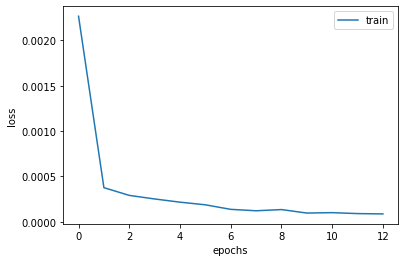

In [144]:
plt.plot(range(len(loss_history)), loss_history, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [145]:
predicted_train_plot = []
net.eval()

for k in range(n_train):
    x = torch.tensor(train[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    predicted_train_plot.append(y[0].item())
    

C:\Users\drryu\AppData\Local\Temp\ipykernel_17948\1814804422.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(train[k])


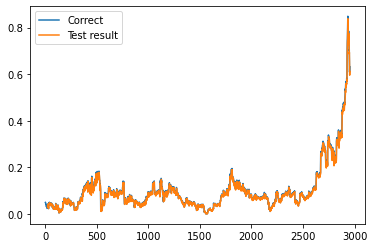

In [146]:

plt.plot(range(len(df_train)), df_train[:, 0], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_train_plot)), predicted_train_plot, label='Test result')
plt.legend()
plt.show()

In [147]:
predicted_test_plot = []
net.eval()

for k in range(n_test):
    x = torch.tensor(test[k])
    x = x.reshape(1, window_size, feature_size)
    x = x.to(device).float()
    y = net(x)
    predicted_test_plot.append(y[0].item())

In [154]:
# テストデータの最後のデータポイントを取得
last_data_point = torch.tensor(test[-1])
last_data_point = last_data_point.reshape(1, window_size, feature_size)
last_data_point = last_data_point.to(device).float()

n_future=300

for k in range(n_future):
    # LSTMモデルを使用して、未来の値を予測
    y = net(last_data_point)
    predicted_test_plot.append(y[0].item())

    # 予測された値をテストデータに追加
    last_data_point = torch.cat((last_data_point[:, 1:, :], y.reshape(1, 1, 1)), axis=1)
    print(len(last_data_point[0]))
# 予測された値を出力

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


In [155]:
df_test

array([[0.66022006],
       [0.64629877],
       [0.62779259],
       ...,
       [0.85795265],
       [0.80576857],
       [0.79984994]])

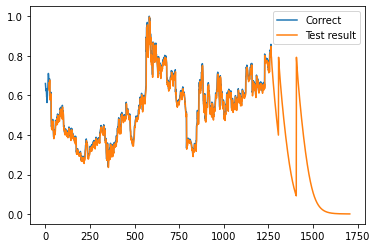

In [156]:
plt.plot(range(len(df_test)), df_test[:, 0], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()

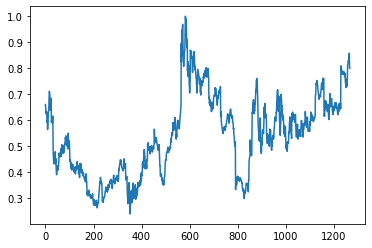

In [157]:
plt.plot(range(len(df_test)), df_test[:, 0], label='Correct')

In [88]:
window_size+len(predicted_test_plot)

76

In [123]:
predicted_test_plot = []
net.eval()

# テストデータの最後のデータポイントを取得
last_data_point = torch.tensor(test[0])
last_data_point = last_data_point.reshape(1, window_size, feature_size)
last_data_point = last_data_point.to(device).float()

n_future=40

for k in range(n_future):
    # LSTMモデルを使用して、未来の値を予測
    y = net(last_data_point)
    predicted_test_plot.append(y[0].item())

    # 予測された値をテストデータに追加
    last_data_point = torch.cat((last_data_point[:, 1:, :], y.reshape(1, 1, 1)), axis=1)
    print(len(last_data_point[0]))
# 予測された値を出力

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


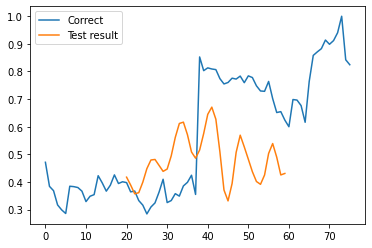

In [125]:
plt.plot(range(len(df_test)), df_test[:, 0], label='Correct')
plt.plot(range(window_size, window_size+len(predicted_test_plot)), predicted_test_plot, label='Test result')
plt.legend()
plt.show()

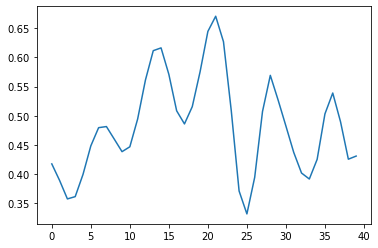

In [124]:
x = range(n_future)
y = predicted_test_plot
plt.plot(x, y, label='Correct')